In [1]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
import bokeh
import scipy
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from collections.abc import Iterable


from utility_functions.utils import read_data, read_press, getnearpos, folder_files, headspace
from utility_functions.utils import getnearpos

In [2]:


#---------------------- DEMS DATA ANALYSIS ---------------------
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    #df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df

def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    
    m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    m = [1.463, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    
    inf_ar = 288.7462016 * demsdata['36']
    
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
       
    return (demsdata) 


def baselinecorr(data, mz, end1, start2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], 'x', label=str(mz))

    
    if mz == 2:
        
        #correct = -2.32525*10**-6*data['time/min'] + 8.70813*10**-4
       # correct = 0.03149263*(data['time/min'])**(-0.08346832)
        #correct =  0.0314373*data['time/min']**(-8.27992*10**-2) #5/25/19 cell 1
        #correct = 2.81138*10**-2*data['time/min']**(-5.04060*10**-2)+.007 #5/25 cell2
        #correct = 2.81138*10**-2*data['time/min']**(-0.06)+.005 #6/27 cell H1
        correct = 0*data['time/min']+.005 #6/27 cell H1
        
    elif mz == 32:
        #correct = 0*data['time/min']+0.0047
        #correct = 0*data['time/min']+0.0058 #cell H1
        #correct = 0*data['time/min']+ 0.0055 #cell A2/B1
        correct = 10**-7*data['time/min']+ 0.0055 #cell C1
        #correct = 3*10**-7*data['time/min']+ 0.0053 #D1
    elif mz ==44:
        
        #correct = -1.78492*10**-6*data['time/min'] + 1.32791*10**-2 +0.001 #5/25 cell 2
        #correct = 0*data['time/min']+0.0105 #cell H1
        #correct = -3*10**-7*data['time/min']+0.009 #A2/B1
        correct = 10**-6*data['time/min']+0.009 #c1/D1
        
    plt.plot(data['time/min'], correct, '.', label='')
    plt.legend()
    plt.show()
    
    data[str(mz)] = data[str(mz)]-correct
    
    return (data)



In [11]:
def plot_naion_dems(chrg_ec, demi, mass_mg, i_uA, title=''):
    num = len(chrg_ec)
    print(num)
    end_ocv= chrg_ec[0]['time/s'].iloc[-1] 
    index1 = getnearpos(demi['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)

    #mass_mg= (mass_mg-28.6)*0.8
    
    #convert ion current to moles of gas for raw  data
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    hydro = baselinecorr( demi, 2, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    co2 = baselinecorr( hydro, 44, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    o2 = baselinecorr( co2, 32, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    umolesdf = o2

    timediff= np.mean(np.gradient(umolesdf['time/min']))
    print(str(timediff) + ' minutes')
    fig,ax = plt.subplots(facecolor='white')
    ax2=ax.twinx()
    
    umoles_2 = np.cumsum(umolesdf['2']).iloc[-1]
    startcap=umolesdf['time/min'].iloc[index1]/60*i_uA/mass_mg
    start_time =umolesdf['time/min'].iloc[index1]/60
    
    print('start capacity: '+ str(startcap))
    
    #ax2.plot(umolesdf['time/min'][index1:]/60*i_uA/mass_mg-startcap, (umolesdf['2'][index1:])/timediff , 'o', markersize=2, label= '2')
#     ax2.plot(umolesdf['time/min'][index1:]/60*i_uA/mass_mg-startcap, (umolesdf['44'][index1:])/timediff , 'o', color= 'xkcd:mid blue', markersize=2, label= '44')
#     ax2.plot(umolesdf['time/min'][index1:]/60*i_uA/mass_mg-startcap, (umolesdf['32'][index1:])/timediff , 'o', color='xkcd:burnt red', markersize=2, label= '32')
    ax2.plot(umolesdf['time/min'][index1:]/60-start_time, (umolesdf['44'][index1:])/timediff , 'o', color= 'xkcd:mid blue', markersize=2, label= 'CO$_2$')
    ax2.plot(umolesdf['time/min'][index1:]/60-start_time, (umolesdf['32'][index1:])/timediff , 'o', color='xkcd:burnt red', markersize=2, label= 'O$_2$')
    
    for i in range(num-2):
        ax.plot(chrg_ec[i+1]['time/s']/3600-start_time , chrg_ec[i+1]['Ewe/V'] , 'k')
    
    #ax.fill_between([27,32], 1.4, color='xkcd:blue', alpha=0.2)
    #ax.fill_between([143,176], 1.4, color='xkcd:blue', alpha=0.2)
    #ax2.spines['right'].set_color('red')
    #ax2.tick_params(axis='y')#, colors='red')
    #ax.spines['left'].set_color('xkcd:cerulean')
    #ax.tick_params(axis='y', colors='xkcd:cerulean')
    
    #ax.set_xlabel('Capacity [mAh/g]')
    ax.set_xlabel('Time [h]')
    ax.set_ylabel('U [V]' , color='k')
    ax2.set_ylabel('Molar Flux of Gas [$\mu$mol/min]')#, color='red')
    ax2.legend()
    ax.set_title(title)
    ax.set_xlim(right=16)
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    
    #umolesdf.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190703_xiaoli_naion_dems_C2/C2 final values.csv')


    return

5


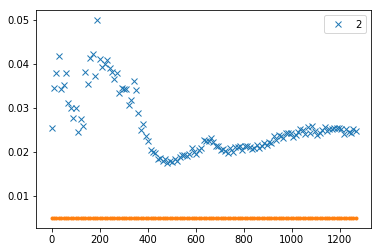

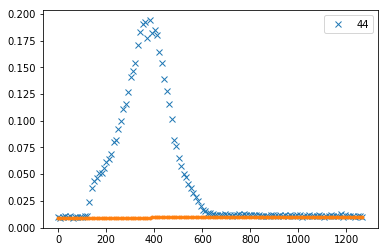

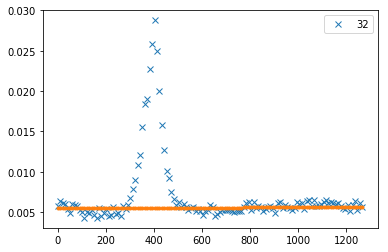

10.051807362204727 minutes
start capacity: 14.452459658119656


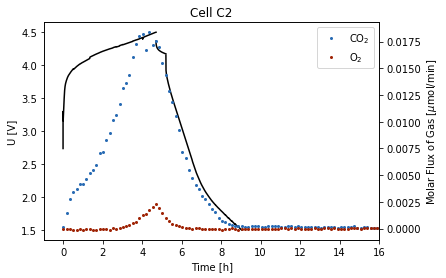

In [12]:
# h1_fold=folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190627_xiaoli_naion_dems_H1/')
# h1_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190627_xiaoli_naion_dems_H1/190627_xiaoli_naion_H1_2019-06-27_09.47_46_ch1.txt')
#h1_converted = convert_ion_current(h1_dems) 
#h1_converted.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/H1 converted currents.csv')

#plot_naion_dems(h1_fold, h1_dems, 17.12, 141.2, 'Cell H1')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190627_xiaoli_naion_dems_H1/H1 cycle plot.png', transparent = True, dpi=600, bbox_inches='tight')



#a2_fold=folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190627_xiaoli_naion_dems_A2/')
#a2_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190627_xiaoli_naion_dems_A2/190627_xiaoli_naion_A2_2019-06-27_09.47_46_ch2.txt')

#plot_naion_dems(a2_fold, a2_dems, 15.6, 312, 'Cell A2')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190627_xiaoli_naion_dems_A2/A2 cycle plot.png', transparent = True, dpi=600, bbox_inches='tight')

#b1_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190702_xiaoli_naion_dems_B1/')
#b1_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190702_xiaoli_naion_dems_B1/190702_xiaoli_naion_dems_B1_2019-07-02_10.10_28_ch1.txt')
#plot_naion_dems(b1_fold, b1_dems, 15.6, 312, 'Cell B1')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190702_xiaoli_naion_dems_B1/B1 cycle plot.png', transparent = True, dpi=600, bbox_inches='tight')


c1_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190703_xiaoli_naion_dems_C2/')
c1_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190703_xiaoli_naion_dems_C2/190703_xiaoli_naion_dems_C2_2019-07-03_12.28_40_ch1.txt')
#plot_naion_dems(c1_fold, c1_dems, 15.6, 112, 'Cell C2')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190703_xiaoli_naion_dems_C2/C2 cycle plot.png', transparent = True, dpi=600, bbox_inches='tight')


#d1_fold = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190703_xiaoli_naion_dems_D1/')
#d1_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190703_xiaoli_naion_dems_D1/190703_xiaoli_naion_dems_D1_ms_2019-07-03_12.28_40_ch2.txt')

#plot_naion_dems(d1_fold, d1_dems, 15.6, 112, 'Cell D1')
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190703_xiaoli_naion_dems_D1/D1 cycle plot.png', transparent = True, dpi=600, bbox_inches='tight')





5


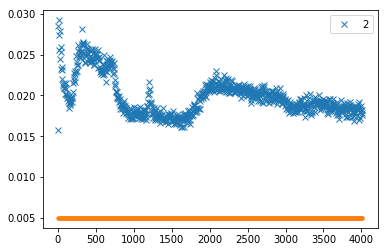

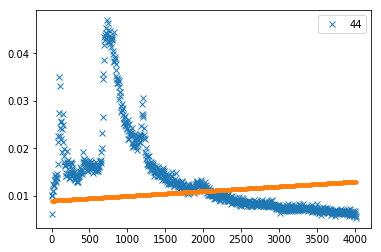

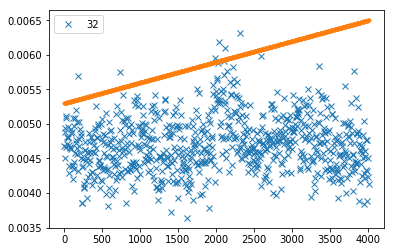

5.0206485 minutes
start capacity: 6.630277866666666


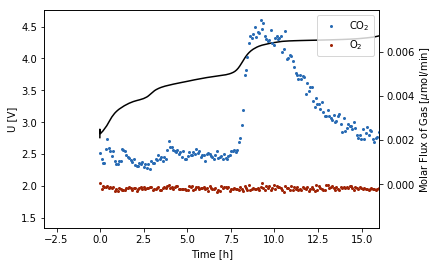

In [6]:

na1= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190524_Naion_xiaolitest_dems_sample1/')
na1_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190524_Naion_xiaolitest_dems_sample1/190524_Naion_xiaolitest_dems_sample1_2019-05-24_11.15_12_ch1.txt')
#umolesna1 = convert_ion_current(na1_dems) 
#umolesna1.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/nacell1.csv')

plot_naion_dems(na1, na1_dems, 42.9, 94.38)

5
5.0206459062499995 minutes
start capacity: 6.79365763686636


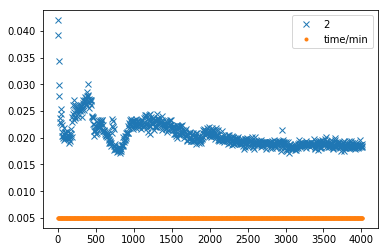

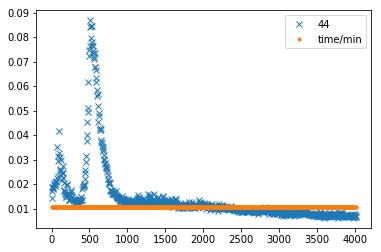

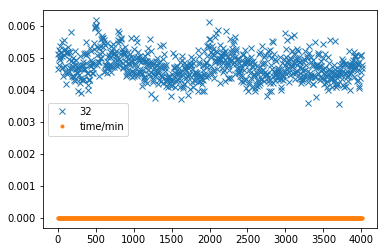

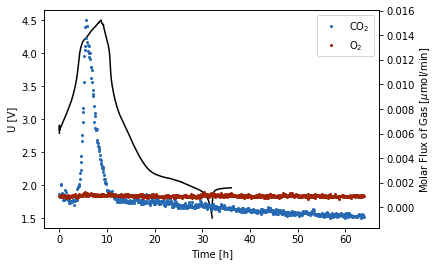

In [199]:
na2= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190524_Naion_xiaolitest_dems_sample2/')
na2_dems= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190524_Naion_xiaolitest_dems_sample2/190524_Naion_xiaolitest_dems_sample2_2019-05-24_11.15_12_ch2.txt')

#umolesna = convert_ion_current(na2_dems) 
#umolesna.to_csv('/Users/kedzie/Documents/Berkeley/Research/Data/2019/convertedcurrents_naion_cell2.csv')



plot_naion_dems(na2, na2_dems, 43.4, 97.92)
#plt.savefig('/Users/kedzie/Desktop/na s2e1 dems.png', transparent = True, dpi=600, bbox_inches='tight')



5
9.981013722627734
start capacity: -31.409090515759306


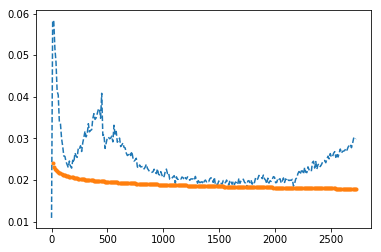

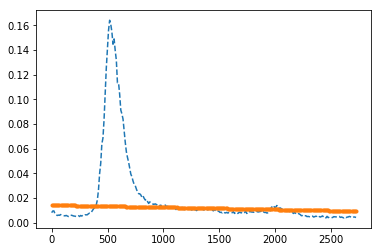

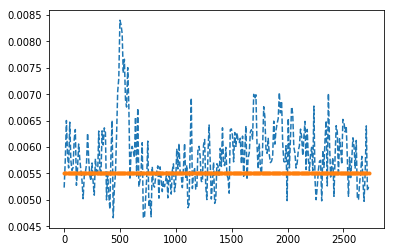

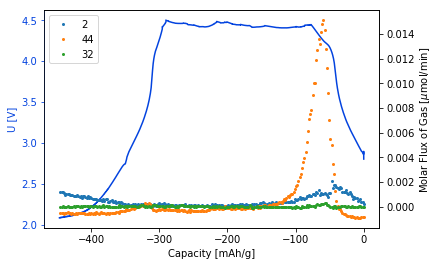

In [165]:
natrial2=folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190601_Naion_xiaoli_dems_e2sample2/')
natrial2_dems=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190601_Naion_xiaoli_dems_e2sample2/190601_Naion_xiaoli_dems_e2sample2_2019-06-01_12.50_02.txt')

plot_naion_dems(natrial2, natrial2_dems, 14.64, 117.12)
#plt.savefig('/Users/kedzie/Desktop/na s2e2 dems.png', transparent = True, dpi=600, bbox_inches='tight')


cumulative o2: 0.06706067045007358
cumulative co2: 0.6754732040833821


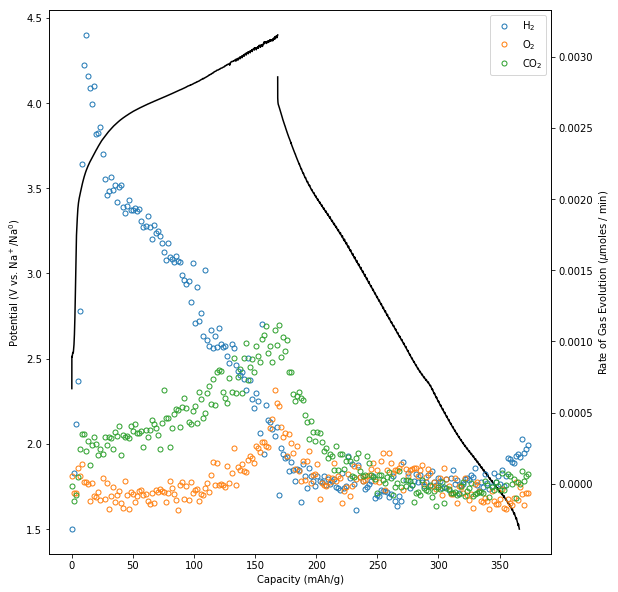

In [4]:
na_ion = folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190309_naIon_xiaoli_c20_dems/cell1/')
ion_dems = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/collaboration data/Xiaoli Na ion/190309_naIon_xiaoli_c20_dems/cell1/190309_naIon_xiaoli_c20_dems_cell1_2019-03-09_15.36_53_ch1.txt')
#mz2= -1.89296*10**-10*np.log(ion_dems['time/min']) + 2.64566*10**-9

mz2= -4.85933*10**-19*ion_dems['time/min']**3 + 2.00656*10**-15*ion_dems['time/min']**2 - 2.42074*10**-12*ion_dems['time/min'] + 1.96360*10**-9
ion_dems['2']= ion_dems['2']-mz2
mz32= -4.88768*10**-12*np.log(ion_dems['time/min']) + 5.25977*10**-11
ion_dems['32']= ion_dems['32']-mz32
mz44= -1.18646*10**-14* ion_dems['time/min'] + 4.81050*10**-11
ion_dems['44']= ion_dems['44']-mz44

index1 = getnearpos(ion_dems['time/min'], na_ion[0]['time/s'].iloc[-1]/60)
timediff= np.mean(np.gradient(ion_dems['time/min']))
    

umoles=convert_ion_current(ion_dems)
start_ch= ion_dems['time/min'].iloc[0]
end_ch= na_ion[1]['time/s']


# oxy = baselinecorr( umoles,32,na_ion[0]['time/s'].iloc[-1],2000)
# hydro = baselinecorr(oxy,2,na_ion[0]['time/s'].iloc[-1],1200)
# co2 = baselinecorr(hydro,44,na_ion[0]['time/s'].iloc[-1],1500)
# c2h4 = baselinecorr(co2,26,na_ion[0]['time/s'].iloc[-1],1500)
# co = baselinecorr(c2h4,28,na_ion[0]['time/s'].iloc[-1],1500)


endcap= na_ion[1]['Capacity/mA.h'].iloc[-1]/.01184
fig, ax= plt.subplots( figsize= (9,10)) 
ax2=ax.twinx()
startcap=umoles['time/min'][index1]/60*0.1184/.01184

ax.plot((na_ion[1]['Capacity/mA.h']/.01184), na_ion[1]['Ewe/V'], 'k')
ax.plot(endcap+(na_ion[3]['Capacity/mA.h']/.01184), na_ion[3]['Ewe/V'], color='k')

ax2.plot(umoles['time/min'][index1:-15]/60*0.1184/.01184-startcap, umoles['2'][index1:-15]/timediff, 'o', markersize=5, mfc='none', label='H$_2$')
ax2.plot(umoles['time/min'][index1:-15]/60*0.1184/.01184-startcap, umoles['32'][index1:-15]/timediff, 'o', markersize=5, mfc='none', label='O$_2$')
ax2.plot(umoles['time/min'][index1:-15]/60*0.1184/.01184-startcap, umoles['44'][index1:-15]/timediff, 'o', markersize=5, mfc='none', label='CO$_2$')

# ax2.fill_between(umoles['time/min'][index1:-15]/60*0.1184/.01184- startcap, 0, umoles['2'][index1:-15]/timediff, color=(0.2, 0.4, 0.6, 0.3), label='')
# ax2.fill(umoles['time/min'][index1:-15]/60*0.1184/.01184 - startcap, umoles['44'][index1:-15]/timediff, color=(0.2, 0.6, 0.2, 0.3), label='')
# ax2.fill(umoles['time/min'][index1:-15]/60*0.1184/.01184 - startcap, umoles['32'][index1:-15]/timediff, color=(0.956, 0.623, 0.184, 0.4), label='')


ax2.legend()
umoles['32'].iloc[0]=0

uo=(np.cumsum(umoles['32']).iloc[-15])
uco2= np.cumsum(umoles['44']).iloc[-15]
ax.set_xlabel("Capacity (mAh/g)")
ax.set_ylabel("Potential (V vs. Na$^+$/Na$^0$)")
ax2.set_ylabel('Rate of Gas Evolution ($\mu$moles / min)')

Final= pd.DataFrame(data=[umoles['time/min'], umoles['2'], umoles['32'], umoles['44']])

print('cumulative o2: '+  str(uo))
print('cumulative co2: '+  str(uco2))
#Final.to_csv('/Users/kedzie/Desktop/xiaolicell1.csv')
#plt.savefig('/Users/kedzie/Desktop/dems_sodiumion_cOver20_dems_cell1.png', transparent = True, dpi=600, bbox_inches='tight')


